In [1]:
# !7z x "/content/easyvqa.zip"

In [2]:
import math
import pandas as pd
import os
from os import path
from tqdm import tqdm
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

from sklearn import preprocessing
import tensorflow as tf
from keras.layers import Input,Dense,LSTM,Flatten,Dropout,concatenate
from keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow import keras
from tensorflow.keras.preprocessing import image, text, sequence
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")


In [3]:
import pandas as pd
df = pd.read_csv("/content/easyVqa.csv")

In [4]:
df.head()

,Unnamed: 0,question,answer,image_path,label
0,0,what is the blue shape?,rectangle,0.png,7
1,1,what color is the shape?,blue,0.png,11
2,2,does the image contain a rectangle?,yes,0.png,4
3,3,is there a triangle in the image?,no,0.png,12
4,4,is there a black shape?,no,0.png,12


In [5]:
labelencoder = preprocessing.LabelEncoder()
labelencoder.fit(df["answer"])
df['class_label'] = labelencoder.transform(list(df['answer']))
total_classes = len(labelencoder.classes_)

In [6]:
X = df[['image_path','question', 'answer']]
y = df['class_label']
print('X.shape:',X.shape)
print('y.shape:',y.shape)

X.shape: (38575, 3)
y.shape: (38575,)


In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10,random_state=42)
Y_train = to_categorical(y_train, total_classes)
Y_val = to_categorical(y_val, total_classes)

In [8]:
t = Tokenizer(filters='')
t.fit_on_texts(list(X_train['question']))
vocab_size = len(t.word_index) + 1
train_sequences = t.texts_to_sequences(list(X_train['question']))
train_padded_docs = pad_sequences(train_sequences, maxlen=22, padding='post')
val_sequences = t.texts_to_sequences(list(X_val['question']))
val_padded_docs = pad_sequences(val_sequences, maxlen=22, padding='post')

In [9]:
import pickle
f = open('/content/drive/MyDrive/ML_final/archive/dataset/glove_vectors', 'rb')
glovevector = pickle.load(f)

In [10]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
	embedding_vector = glovevector.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

(33, 300)


In [17]:
class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, indpt_qstn, indpt_img, target,batch_size,shuffle=True):
        self.indpt_qstn = indpt_qstn
        self.indpt_img = indpt_img
        self.target = target
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes_list = np.arange(len(target))
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes_list = np.random.permutation(self.indexes_list)
    def __get_input1(self, qstn_item):
        qstns_set = (pad_sequences(t.texts_to_sequences([qstn_item]), maxlen=22, padding='post'))[0]
        return qstns_set
    def __get_input2(self, path):
        raw_img = cv2.imread(path)
        resized_img = cv2.resize(raw_img, (224, 224))
        img = np.array(resized_img)/255.0
        return img
    def __get_output(self, label):
        return tf.keras.utils.to_categorical(label, num_classes=total_classes)
    def __getitem__(self, current_index):
        indpt_qstn_item = self.indpt_qstn[current_index * self.batch_size:(current_index + 1) * self.batch_size]
        indpt_img_item = self.indpt_img[current_index * self.batch_size:(current_index + 1) * self.batch_size]
        target_items = self.target[current_index * self.batch_size:(current_index + 1) * self.batch_size]
        Trained_qstn = np.asarray([self.__get_input1(qstn_item) for qstn_item in indpt_qstn_item])
        Trained_img = np.asarray([self.__get_input2(colab_path+'/'+path) for path in indpt_img_item])
        target_val_set = np.asarray([self.__get_output(c) for c in target_items])
        return tuple([Trained_qstn, Trained_img]), target_val_set
    def __len__(self):
        return len(self.indexes_list) // self.batch_size

colab_path = "/content/data/train/images"
batch_size = 64
traingen = CustomDataGen(list(X_train['question']),list(X_train['image_path']),list(y_train),batch_size=batch_size)
valgen = CustomDataGen(list(X_val['question']),list(X_val['image_path']),list(y_val),batch_size=batch_size)

In [13]:
pre_trained_model = tf.keras.applications.VGG19(input_shape=(224, 224, 3), include_top=True, weights="imagenet", pooling='avg')

for layer in pre_trained_model.layers:
    layer.trainable = False

regularizer = tf.keras.regularizers.l2(0.01)

for layer in pre_trained_model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)

vgg_fully_2 = (pre_trained_model.get_layer('fc2')).output

dense_out = Dense(units=1024,activation='relu',kernel_initializer='he_normal')(vgg_fully_2)

dense_out = Dropout(0.2)(dense_out)

input_2 = Input(shape=(22,))

embedding = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=22, trainable=False)(input_2)

lstm1 = LSTM(64, return_sequences=True)(embedding)

dropout1 = Dropout(0.5)(lstm1)

lstm2 = LSTM(64)(dropout1)

dropout2 = Dropout(0.5)(lstm2)

que = Dense(units=1024,activation='relu',kernel_initializer='he_normal')(dropout2)

pointwise_mul = tf.math.multiply(que, dense_out)

output = Dense(units=total_classes,activation='softmax',kernel_initializer="glorot_uniform")(pointwise_mul)

vgg19_lstm = Model(inputs=[input_2,pre_trained_model.input],outputs=output)
# compile

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

vgg19_lstm.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

vgg19_lstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

In [15]:
checkpoint_filepath="./weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

In [18]:
vgg19_lstm_summary = vgg19_lstm.fit(traingen,batch_size=64,epochs=4,verbose=1,validation_data=valgen,callbacks=[model_checkpoint_callback])

Epoch 1/4
542/542 [==============================] - 192s 331ms/step - loss: 1.1026 - accuracy: 0.5425 - val_loss: 0.7531 - val_accuracy: 0.6888
Epoch 2/4
542/542 [==============================] - 182s 336ms/step - loss: 0.7392 - accuracy: 0.7045 - val_loss: 0.6288 - val_accuracy: 0.7526
Epoch 3/4
542/542 [==============================] - 185s 341ms/step - loss: 0.6443 - accuracy: 0.7477 - val_loss: 0.6056 - val_accuracy: 0.7589
Epoch 4/4
542/542 [==============================] - 183s 337ms/step - loss: 0.6256 - accuracy: 0.7531 - val_loss: 0.5971 - val_accuracy: 0.7820


In [19]:
#predictions
testgen = CustomDataGen(list(X_train['question'][:20]),list(X_train['image_path'][:20]),list(y_train)[:20],batch_size=20)

In [21]:
ans = vgg19_lstm.predict(testgen)

1/1 [==============================] - 4s 4s/step


In [22]:
predicted_ans = []
for i in ans:
  a = labelencoder.inverse_transform([np.argmax(i)])
  predicted_ans.append(a[0])


In [23]:
test_image_path = list(X_train['image_path'][:20])
test_question = list(X_train['question'][:20])
test_answer = list(y_train[:20])


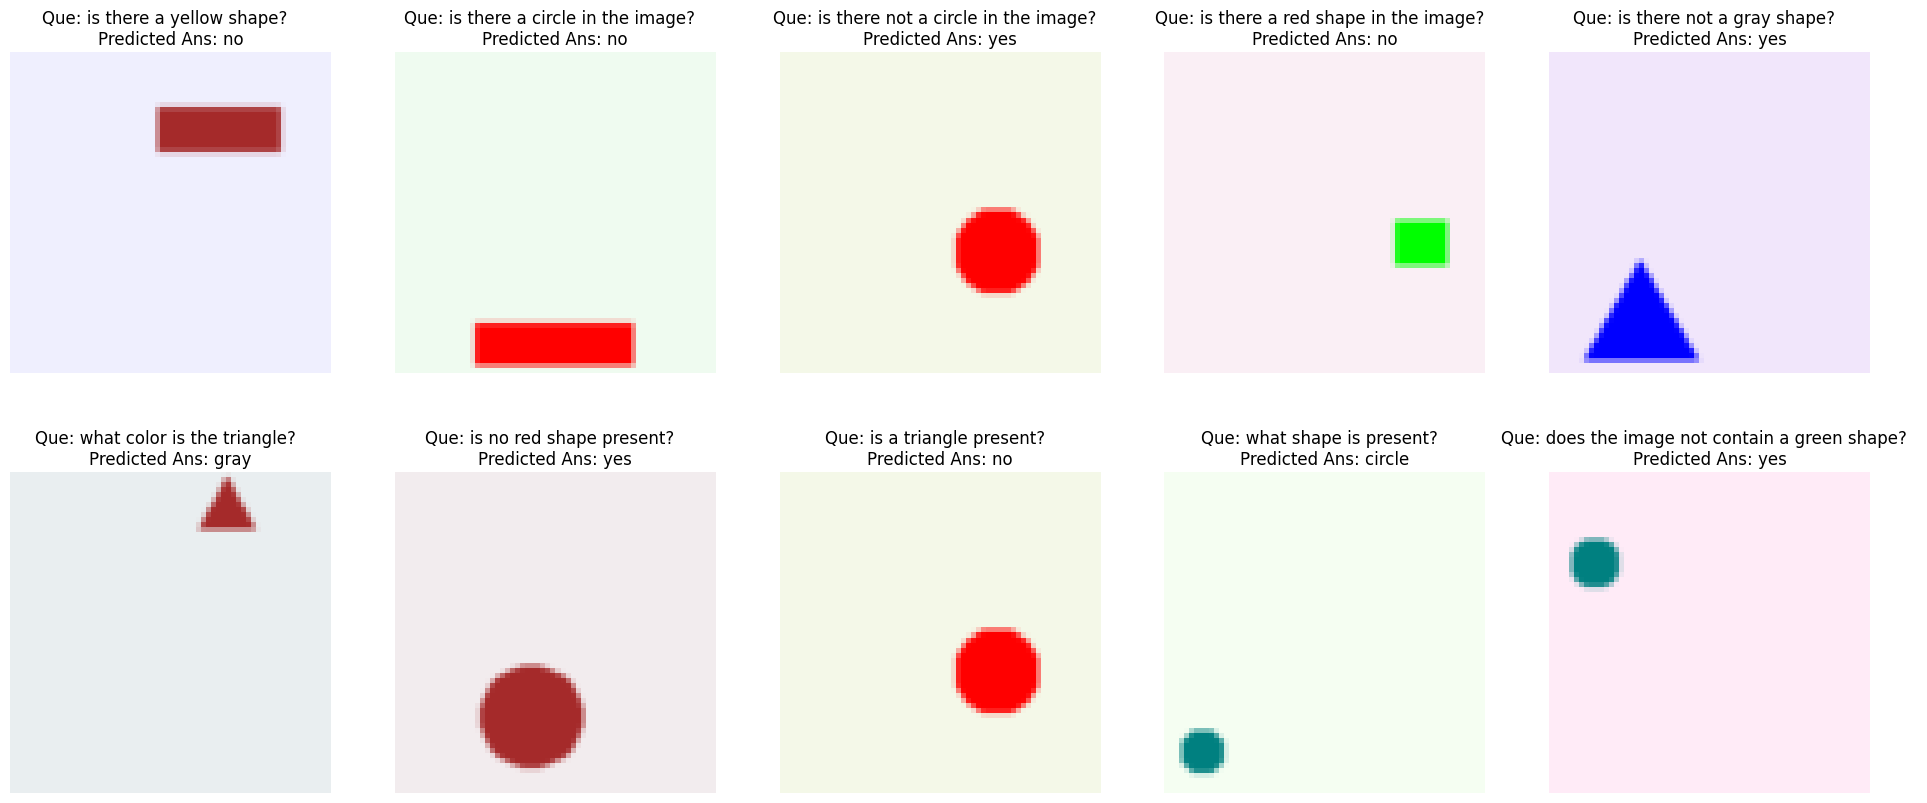

In [24]:

# Plot test images, questions, actual answers and predicted answers
fig = plt.figure(figsize=(24, 10))
for a,i in enumerate(list(np.arange(10))):
  fig.add_subplot(2, 5, a+1)
  img = cv2.imread(colab_path+'/'+test_image_path[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img); plt.axis('off')
  plt.title(f'Que: {test_question[i]}  \nPredicted Ans: {predicted_ans[i]}')


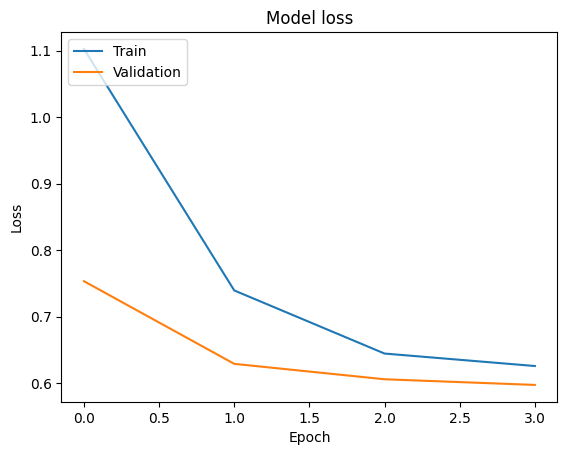

In [25]:
import matplotlib.pyplot as plt
plt.plot(vgg19_lstm_summary.history['loss'])
plt.plot(vgg19_lstm_summary.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


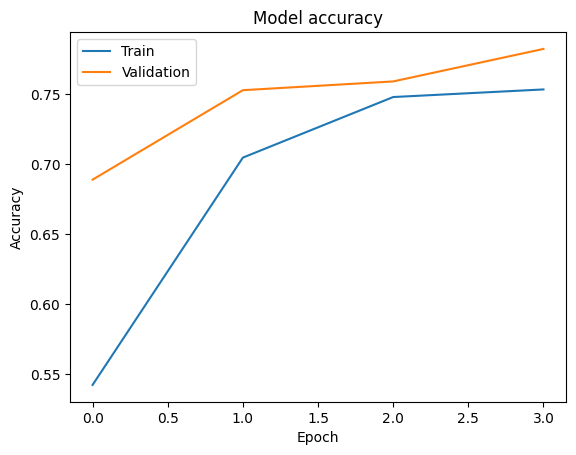

In [26]:
plt.plot(vgg19_lstm_summary.history['accuracy'])
plt.plot(vgg19_lstm_summary.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()